# EN3160 Assignment 3 on Neural Networks

Sundarbavan T.    
210624E

### Question 1

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.0373199665546418
Epoch 2/10, Loss: 1.7760098135471345
Epoch 3/10, Loss: 1.691102845788002
Epoch 4/10, Loss: 1.635230519771576
Epoch 5/10, Loss: 1.5896104815006256
Epoch 6/10, Loss: 1.5471722894906998
Epoch 7/10, Loss: 1.5061762708425521
Epoch 8/10, Loss: 1.4682005385160446
Epoch 9/10, Loss: 1.431894237279892
Epoch 10/10, Loss: 1.397979984521866


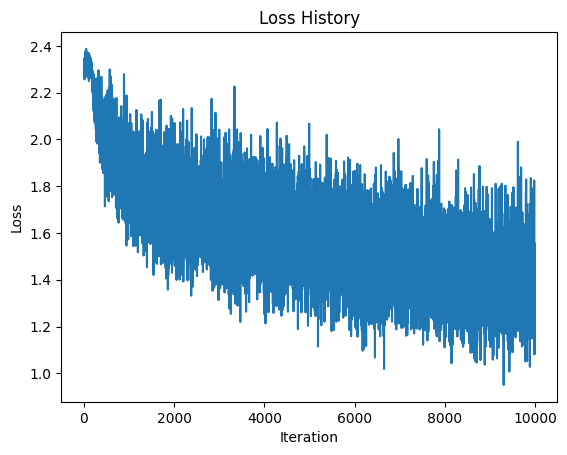

Training accuracy: 53.29%
Test accuracy: 47.97%


In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Number of nodes in the hidden layer
K = 10   # Output size (number of classes in CIFAR-10)

# Initialize weights and biases as Parameters to enable gradient calculation
w1 = nn.Parameter(torch.randn(Din, H) * 1e-5)
b1 = nn.Parameter(torch.zeros(H))
w2 = nn.Parameter(torch.randn(H, K) * 1e-5)
b2 = nn.Parameter(torch.zeros(K))

# Hyperparameters
iterations = 10
lr = 1e-1  # Learning rate
lr_decay = 1  # Learning rate decay
reg = 0  # Regularization
loss_history = []

# Loss function
criterion = nn.CrossEntropyLoss()

# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)

        # Forward pass
        hidden = torch.sigmoid(x_train.mm(w1) + b1)  # Hidden layer activation with sigmoid
        y_pred = hidden.mm(w2) + b2  # Output layer

        # Loss calculation
        loss = criterion(y_pred, labels) + reg * (torch.sum(w1**2) + torch.sum(w2**2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Parameter update
        with torch.no_grad():
            w1 -= lr * w1.grad
            b1 -= lr * b1.grad
            w2 -= lr * w2.grad
            b2 -= lr * b2.grad

            # Zero the gradients after updating
            w1.grad.zero_()
            b1.grad.zero_()
            w2.grad.zero_()
            b2.grad.zero_()

    # Learning rate decay
    lr *= lr_decay
    print(f"Epoch {t + 1}/{iterations}, Loss: {running_loss / len(trainloader)}")

# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        hidden = torch.sigmoid(x_train.mm(w1) + b1)
        y_train_pred = hidden.mm(w2) + b2
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        hidden = torch.sigmoid(x_test.mm(w1) + b1)
        y_test_pred = hidden.mm(w2) + b2
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()
test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Training accuracy: 53.29%     
Test accuracy: 47.97%

### Question 2

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define the LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Initialize fc1 based on the flattened size after conv2 and pooling
        self.fc1_input_size = self._get_fc1_input_size()
        self.fc1 = nn.Linear(self.fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def _get_fc1_input_size(self):
        # Pass a dummy input through conv and pool layers to determine the size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 32, 32)
            x = self.pool(torch.tanh(self.conv1(dummy_input)))
            x = self.pool(torch.tanh(self.conv2(x)))
            return x.numel()

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST data
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 as LeNet-5 expects
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training Loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}, Training Accuracy: {train_acc:.2f}%")

# Evaluate on test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test Accuracy: {test_acc:.2f}%")


Epoch 1, Loss: 0.4043, Training Accuracy: 87.75%
Epoch 2, Loss: 0.1000, Training Accuracy: 97.04%
Epoch 3, Loss: 0.0664, Training Accuracy: 97.99%
Epoch 4, Loss: 0.0517, Training Accuracy: 98.42%
Epoch 5, Loss: 0.0416, Training Accuracy: 98.72%
Epoch 6, Loss: 0.0359, Training Accuracy: 98.91%
Epoch 7, Loss: 0.0313, Training Accuracy: 99.07%
Epoch 8, Loss: 0.0280, Training Accuracy: 99.13%
Epoch 9, Loss: 0.0221, Training Accuracy: 99.39%
Epoch 10, Loss: 0.0203, Training Accuracy: 99.42%
Test Accuracy: 98.63%


Training Accuracy: 99.42%   
Test Accuracy: 98.63%

### Question 3

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import zipfile


# Path to the uploaded ZIP file
zip_file_path = '/content/drive/MyDrive/archive.zip'

# Extract to a specific directory
extract_dir = '/content/hymenoptera_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data transformations
data_dir = '/content/hymenoptera_data/hymenoptera'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                scheduler.step()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# Criterion
criterion = nn.CrossEntropyLoss()

# ===================
# Fine-Tuning Approach
# ===================
print("\n--- Fine-Tuning ResNet18 ---")

# Load pre-trained ResNet18
model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Optimizer and scheduler
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model with fine-tuning
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# Save fine-tuned model
torch.save(model_ft.state_dict(), 'fine_tuned_resnet18.pth')

# =========================
# Feature Extraction Approach
# =========================
print("\n--- Feature Extraction ResNet18 ---")

# Load pre-trained ResNet18
model_conv = models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

# Optimizer and scheduler
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train the model with feature extraction
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

# Save feature-extracted model
torch.save(model_conv.state_dict(), 'feature_extractor_resnet18.pth')



--- Fine-Tuning ResNet18 ---
Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.6107 Acc: 0.6967
val Loss: 0.4392 Acc: 0.8105
Epoch 1/9
----------
train Loss: 0.5100 Acc: 0.7910
val Loss: 0.3369 Acc: 0.8889
Epoch 2/9
----------
train Loss: 0.4643 Acc: 0.7787
val Loss: 0.2833 Acc: 0.8954
Epoch 3/9
----------
train Loss: 0.3911 Acc: 0.8361
val Loss: 0.2473 Acc: 0.9412
Epoch 4/9
----------
train Loss: 0.4534 Acc: 0.7705
val Loss: 0.2386 Acc: 0.9281
Epoch 5/9
----------
train Loss: 0.3744 Acc: 0.8525
val Loss: 0.2262 Acc: 0.9477
Epoch 6/9
----------
train Loss: 0.3988 Acc: 0.8197
val Loss: 0.2121 Acc: 0.9346
Epoch 7/9
----------
train Loss: 0.3525 Acc: 0.8484
val Loss: 0.2187 Acc: 0.9412
Epoch 8/9
----------
train Loss: 0.3498 Acc: 0.8566
val Loss: 0.2223 Acc: 0.9281
Epoch 9/9
----------
train Loss: 0.3609 Acc: 0.8484
val Loss: 0.2079 Acc: 0.9346
Training complete in 0m 15s
Best val Acc: 0.9477

--- Feature Extraction ResNet18 ---
Epoch 0/9
----------
train Loss: 0.7132 Acc: 0.5082
val Loss: 0.6029 Acc: 0.6993
Epoch 1/9
----------
train Loss: 0.6095 Acc:

Best validation accuracy with fine-tuning: 0.9477

Best validation accuracy with feature extraction: 0.9346